In [51]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [52]:
def find_largest_contour(image):
    """
    This function finds all the contours in an image and return the largest
    contour area.
    :param image: a binary image
    """
    image = image.astype(np.uint8)
    contours, hierarchy = cv2.findContours(
        image,
        cv2.RETR_TREE,
        cv2.CHAIN_APPROX_SIMPLE
    )
    largest_contour = max(contours, key=cv2.contourArea)
    return largest_contour

In [53]:
def show(image):
    """
    A simple function to visualize OpenCV images on screen.
    :param name: a string signifying the imshow() window name
    :param image: NumPy image to show 
    """
    plt.imshow(image)

In [54]:
def apply_new_background(mask3d, foreground, save_name):
    """
    This function applies a new background to the extracted foreground image
    if `--new-background` flag is `True` while executing the file.
    :param mask3d: mask3d mask containing the foreground binary pixels
    :param foreground: mask containg the extracted foreground image
    :param save_name: name of the input image file
    """
    # normalization of mask3d mask, keeping values between 0 and 1
    mask3d = mask3d / 255.0
    # get the scaled product by multiplying
    foreground = cv2.multiply(mask3d, foreground)
    # read the new background image
    background = cv2.imread('input/background.jpg')
    # resize it according to the foreground image
    background = cv2.resize(background, (foreground.shape[1], foreground.shape[0]))
    background = background.astype(np.float)
    # get the scaled product by multiplying
    background = cv2.multiply(1.0 - mask3d, background)
    # add the foreground and new background image
    new_image = cv2.add(foreground, background)
    show('New image', new_image.astype(np.uint8))
    cv2.imwrite(f"outputs/{save_name}_new_background.jpg", new_image)

In [55]:
mask_path = "datasets/Endovis2017/visual_prompt/no_combination/binary_segmentation/instrument/mask/bipolar_forceps.jpg"

In [56]:
img_path = "datasets/Endovis2017/visual_prompt/no_combination/binary_segmentation/instrument/img/bipolar_forceps.jpg"

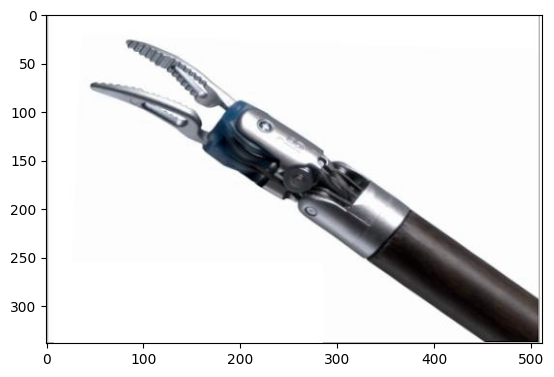

In [57]:
image = cv2.imread(img_path)
imgplot = plt.imshow(image)
plt.show()

In [69]:


# blur the image to smmooth out the edges a bit, also reduces a bit of noise
blurred = cv2.GaussianBlur(image, (5, 5), 0)
# convert the image to grayscale 
gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
# apply thresholding to conver the image to binary format
# after this operation all the pixels below 200 value will be 0...
# and all th pixels above 200 will be 255
ret, gray = cv2.threshold(gray, 200 , 255, cv2.CHAIN_APPROX_NONE)

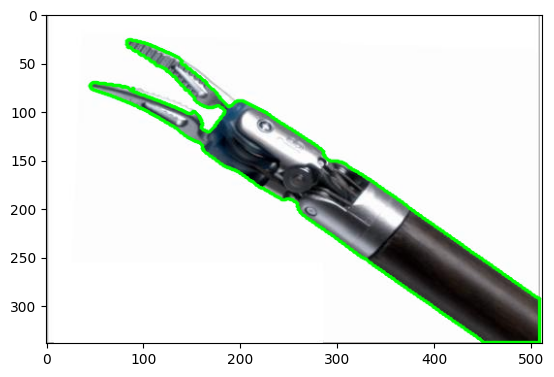

In [70]:
contour = find_largest_contour(gray)
image_contour = np.copy(image)
cv2.drawContours(image_contour, [contour], 0, (0, 255, 0), 2, cv2.LINE_AA, maxLevel=1)

plt.imshow(image_contour)
plt.show()

In [71]:
mask = np.zeros_like(gray)
# fill the new mask with the shape of the largest contour
# all the pixels inside that area will be white 
cv2.fillPoly(mask, [contour], 255)
# create a copy of the current mask
res_mask = np.copy(mask)
res_mask[mask == 0] = cv2.GC_BGD # obvious background pixels
res_mask[mask == 255] = cv2.GC_PR_BGD # probable background pixels
res_mask[mask == 255] = cv2.GC_FGD # obvious foreground pixels

mask2 = np.where(
    (res_mask == cv2.GC_FGD) | (res_mask == cv2.GC_PR_FGD),
    255,
    0
).astype('uint8')

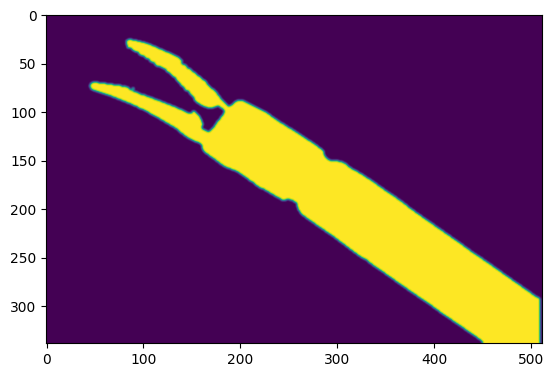

In [74]:
# create `new_mask3d` from `mask2` but with 3 dimensions instead of 2
new_mask3d = mask2
mask3d = new_mask3d
mask3d[new_mask3d > 0] = 255.0
mask3d[mask3d > 255] = 255.0
# apply Gaussian blurring to smoothen out the edges a bit
# `mask3d` is the final foreground mask (not extracted foreground image)
mask3d = cv2.GaussianBlur(mask3d, (5, 5), 0)
plt.imshow(mask3d)
plt.show()

code from https://debuggercafe.com/image-foreground-extraction-using-opencv-contour-detection/